In [1]:
%matplotlib inline


# High level interface

Introduction to 3D analysis using the Gammapy high level interface.

## Prerequisites

-  Understanding the gammapy data workflow, in particular what are DL3
   events and instrument response functions (IRF).

## Context

This notebook is an introduction to gammapy analysis using the high
level interface.

Gammapy analysis consists in two main steps.

The first one is data reduction: user selected observations are reduced
to a geometry defined by the user. It can be 1D (spectrum from a given
extraction region) or 3D (with a sky projection and an energy axis). The
resulting reduced data and instrument response functions (IRF) are
called datasets in Gammapy.

The second step consists in setting a physical model on the datasets and
fitting it to obtain relevant physical information.

![gpy_data_flow](images/data-flow-gammapy.png)


**Objective: Create a 3D dataset of the Crab using the H.E.S.S. DL3 data
release 1 and perform a simple model fitting of the Crab nebula.**

## Proposed approach

This notebook uses the high level `~gammapy.analysis.Analysis` class to orchestrate data
reduction. In its current state, `~gammapy.analysis.Analysis` supports the standard
analysis cases of joint or stacked 3D and 1D analyses. It is
instantiated with an `~gammapy.analysis.AnalysisConfig` object that gives access to
analysis parameters either directly or via a YAML config file.

In summary, we have to:

-  Create an `~gammapy.analysis.AnalysisConfig` object and edit it to
   define the analysis configuration:

   -  Define what observations to use
   -  Define the geometry of the dataset (data and IRFs)
   -  Define the model we want to fit on the dataset.

-  Instantiate a `~gammapy.analysis.Analysis` from this configuration
   and run the different analysis steps

   -  Observation selection
   -  Data reduction
   -  Model fitting
   -  Estimating flux points

Finally we will compare the results against a reference model.


## Setup




In [2]:
# %matplotlib inline
from pathlib import Path
from astropy import units as u
from gammapy.analysis import Analysis, AnalysisConfig

## Analysis configuration

For configuration of the analysis we use the
[YAML](https://en.wikipedia.org/wiki/YAML)_ data format. YAML is a
machine readable serialisation format, that is also friendly for humans
to read. In this tutorial we will write the configuration file just
using Python strings, but of course the file can be created and modified
with any text editor of your choice.

Here is what the configuration for our analysis looks like:




In [3]:
config = AnalysisConfig()
# the AnalysisConfig gives access to the various parameters used from logging to reduced dataset geometries
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                width: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 1.0 TeV, max: 10.0 TeV, nbins: 5}
                energy_true: {min: 0.5 TeV, max: 20.0 TeV, nbins: 16}
        map_selection: [counts, exposure, background, psf, ed

### Setting the data to use




We want to use Crab runs from the H.E.S.S. DL3-DR1. We define here the
datastore and a cone search of observations pointing with 5 degrees of
the Crab nebula. Parameters can be set directly or as a python dict.

In [4]:
# We define the datastore containing the data
config.observations.datastore = "hess-dl3-dr1"

# We define the cone search parameters
config.observations.obs_cone.frame = "icrs"
config.observations.obs_cone.lon = "83.633 deg"
config.observations.obs_cone.lat = "22.014 deg"
config.observations.obs_cone.radius = "5 deg"

# Equivalently we could have set parameters with a python dict
# config.observations.obs_cone = {"frame": "icrs", "lon": "83.633 deg", "lat": "22.014 deg", "radius": "5 deg"}

### Setting the reduced datasets geometry




In [5]:
# We want to perform a 3D analysis
config.datasets.type = "3d"
# We want to stack the data into a single reduced dataset
config.datasets.stack = True

# We fix the WCS geometry of the datasets
config.datasets.geom.wcs.skydir = {
    "lon": "83.633 deg",
    "lat": "22.014 deg",
    "frame": "icrs",
}
config.datasets.geom.wcs.width = {"width": "2 deg", "height": "2 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# We now fix the energy axis for the counts map
config.datasets.geom.axes.energy.min = "1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We now fix the energy axis for the IRF maps (exposure, etc)
config.datasets.geom.axes.energy_true.min = "0.5 TeV"
config.datasets.geom.axes.energy_true.max = "20 TeV"
config.datasets.geom.axes.energy_true.nbins = 20

### Setting the background normalization maker




In [6]:
config.datasets.background.method = "fov_background"
config.datasets.background.parameters = {"method": "scale"}

### Setting the exclusion mask




In order to properly adjust the background normalisation on regions
without gamma-ray signal, one needs to define an exclusion mask for the
background normalisation. For this tutorial, we use the following one
``joint-crab/exclusion/exclusion_mask_crab.fits.gz``




In [7]:
config.datasets.background.exclusion = (
    "joint-crab/exclusion/exclusion_mask_crab.fits.gz"
)

This is the exclusion mask defined in the exclusion_mask_crab.fits.gz file

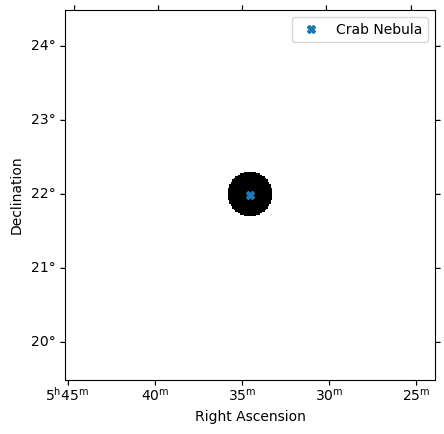

In [8]:
from astropy.io import fits
from gammapy.maps import Map
import matplotlib.pyplot as plt

with fits.open("joint-crab/exclusion/exclusion_mask_crab.fits.gz") as hdul:    
    exclusion_map=Map.from_hdulist(hdul)
    
exclusion_map.plot()

from astropy.coordinates import SkyCoord
Crab_pos=SkyCoord.from_name("Crab Nebula")

plt.plot(Crab_pos.to_pixel(exclusion_map.geom.wcs)[0],
         Crab_pos.to_pixel(exclusion_map.geom.wcs)[1],
         "X",label="Crab Nebula")
plt.legend();

### Setting modeling and fitting parameters

``Analysis`` can perform a few modeling and fitting tasks besides data
reduction. Parameters have then to be passed to the configuration
object.

Here we define the energy range on which to perform the fit. We also set
the energy edges used for flux point computation as well as the
correlation radius to compute excess and significance maps.




In [9]:
config.fit.fit_range.min = 1 * u.TeV
config.fit.fit_range.max = 10 * u.TeV
config.flux_points.energy = {"min": "1 TeV", "max": "10 TeV", "nbins": 4}
config.excess_map.correlation_radius = 0.1 * u.deg

## Running the analysis

We first create an `~gammapy.analysis.Analysis` object from our
configuration.




In [10]:
analysis_stacked = Analysis(config)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


### Observation selection

We can directly select and load the observations from disk using
`~gammapy.analysis.Analysis.get_observations()`:




In [11]:
analysis_stacked.get_observations()

Fetching observations.
Observations selected: 4 out of 4.
Number of selected observations: 4


The observations are now available on the `~gammapy.modeling.Analysis` object. The
selection corresponds to the following ids:




In [12]:
print(analysis_stacked.observations.ids)

['23523', '23526', '23559', '23592']


## Data reduction

Now we proceed to the data reduction. In the config file we have chosen
a WCS map geometry, energy axis and decided to stack the maps. We can
run the reduction using `~gammapy.modeling.Analysis.get_datasets()`:




In [13]:
analysis_stacked.get_datasets()

Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Computing dataset for observation 23523
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 23526
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 23559
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 23592
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker


As we have chosen to stack the data, there is finally one dataset
contained which we can print:




In [14]:
print(analysis_stacked.datasets["stacked"])

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 2485 
  Total background counts         : 1997.49
  Total excess counts             : 487.51

  Predicted counts                : 1997.49
  Predicted background counts     : 1997.49
  Predicted excess counts         : nan

  Exposure min                    : 2.73e+08 m2 s
  Exposure max                    : 3.52e+09 m2 s

  Number of total bins            : 100000 
  Number of fit bins              : 100000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




As you can see the dataset comes with a predefined background model out
of the data reduction, but no source model has been set yet.

The counts, exposure and background model maps are directly available on
the dataset and can be printed and plotted:




In [15]:
counts = analysis_stacked.datasets["stacked"].counts
counts.smooth("0.05 deg").plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

We can also compute the map of the sqrt_ts (significance) of the excess
counts above the background. The correlation radius to sum counts is
defined in the config file.




Computing excess maps.


<WCSAxesSubplot: >

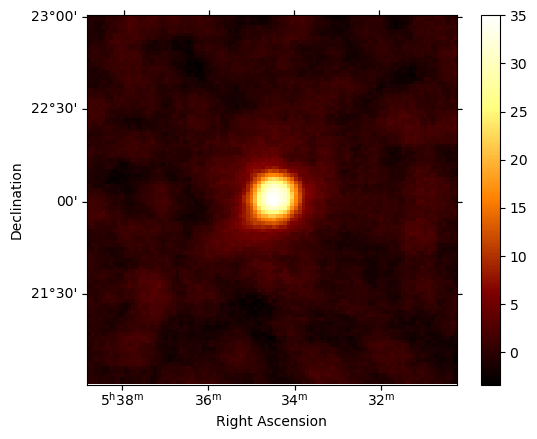

In [16]:
analysis_stacked.get_excess_map()
analysis_stacked.excess_map["sqrt_ts"].plot(add_cbar=True)

## Model fitting

Now we define a model to be fitted to the dataset. Here we use its YAML
definition to load it:




In [17]:
model_config = """
components:
- name: crab
  type: SkyModel
  spatial:
    type: PointSpatialModel
    frame: icrs
    parameters:
    - name: lon_0
      value: 83.63
      unit: deg
    - name: lat_0
      value: 22.014
      unit: deg
  spectral:
    type: PowerLawSpectralModel
    parameters:
    - name: amplitude
      value: 1.0e-12
      unit: cm-2 s-1 TeV-1
    - name: index
      value: 2.0
      unit: ''
    - name: reference
      value: 1.0
      unit: TeV
      frozen: true
"""

Now we set the model on the analysis object:




In [18]:
analysis_stacked.set_models(model_config)

Reading model.
Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :     83.630   +/-    0.00 deg         
    lat_0                         :     22.014   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : stacked-bkg
  Datasets names            : ['stacked']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000

Finally we run the fit:




In [19]:
analysis_stacked.run_fit()
print(analysis_stacked.fit_result)

Fitting datasets.
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 269
	total stat : 19991.99

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 269
	total stat : 19991.99

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



### Flux points




Calculating flux points.
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend

      e_ref                 dnde          ...      sqrt_ts      
       TeV            1 / (cm2 s TeV)     ...                   
------------------ ---------------------- ... ------------------
1.2589254117941673 2.3566080710306704e-11 ... 24.265126817481395
1.9952623149688797  8.856741343237395e-12 ... 22.402061314580322
3.1622776601683795  2.488908717904057e-12 ... 16.767167369644568
 5.011872336272723  6.151504860641491e-13 ... 11.905979369095887
 7.943282347242818 2.4384510432396403e-13 ...  8.

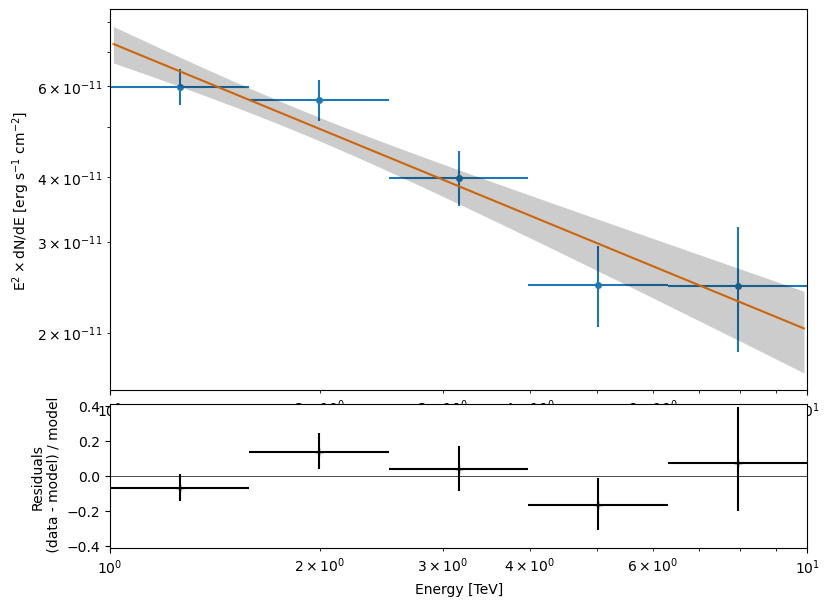

In [20]:
#set the source name to compute the flux points
analysis_stacked.config.flux_points.source = "crab"

# Example showing how to change the FluxPointsEstimator parameters:
analysis_stacked.config.flux_points.energy.nbins = 5
config_dict = {
    "selection_optional": "all",
    "n_sigma": 1,  # Number of sigma to use for asymmetric error computation
    "n_sigma_ul": 2,  # Number of sigma to use for upper limit computation
}

# specify the parameters of the flux_points config
analysis_stacked.config.flux_points.parameters = config_dict

analysis_stacked.get_flux_points()

# Example showing how to change just before plotting the threshold on the signal significance
# (points vs upper limits), even if this has no effect with this data set.
fp = analysis_stacked.flux_points.data
fp.sqrt_ts_threshold_ul = 2

#plot
ax_sed, ax_residuals = analysis_stacked.flux_points.plot_fit()
ax_sed.set_ylabel(fr"E$^2 \times$dN/dE [erg s$^{{-1}}$ cm$^{{-2}}$]");

To check the fit is correct, we compute the map of the sqrt_ts of the
excess counts above the current model.




Computing excess maps.


<WCSAxesSubplot: >

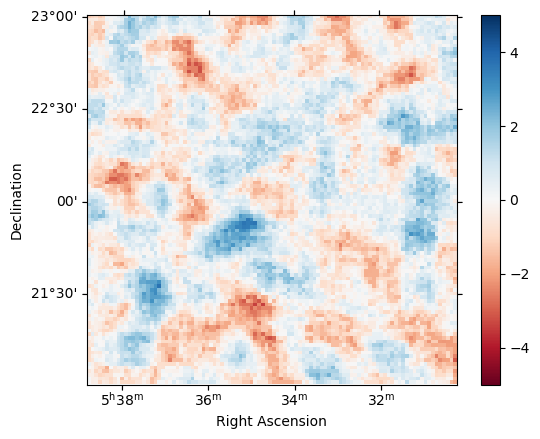

In [21]:
analysis_stacked.get_excess_map()
analysis_stacked.excess_map["sqrt_ts"].plot(add_cbar=True, cmap="RdBu", vmin=-5, vmax=5)

# Light curve

Since we stacked the observations, we would obtain a single integral flux point for all observations. Thus, we have to do the analysis without stacking the observations.

In [22]:
import copy
config_join = copy.deepcopy(config)
config_join.datasets.stack = False

analysis_join = Analysis(config_join)
analysis_join.get_observations()
analysis_join.get_datasets()
analysis_join.set_models(model_config)
analysis_join.run_fit()


analysis_join.config.light_curve.energy_edges.min = 1*u.TeV
analysis_join.config.light_curve.energy_edges.max = 10*u.TeV
analysis_join.config.light_curve.energy_edges.nbins = 1
analysis_join.config.light_curve.source = "crab"

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 4 out of 4.
Number of selected observations: 4
Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Computing dataset for observation 23523
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 23526
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 23559
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 23592
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Reading model.
Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type      

In [23]:
analysis_join.get_light_curve()

Computing light curve.
Time intervals not defined. Extract light curve on datasets GTIs.
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend

     time_min           time_max      ...               stat_scan               
                                      ...                                       
------------------ ------------------ ... --------------------------------------
53343.922340092584  53343.94186555555 ... 8294.528318656094 .. 8818.038823588931
53343.954215092584  53343.97369425925 ... 7110.485912465154 .. 7630.203967847612
 53345.96198129629  53345.98149518518 ... 5105.350649241877 .. 5335.996338518304
 53347.91319657407 53347.932710462956 ... 6464.1

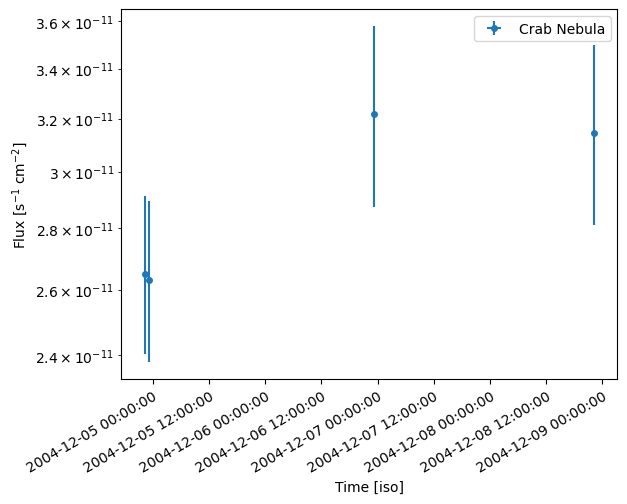

In [24]:
ax_flux = analysis_join.light_curve.plot(axis_name="time", sed_type="flux", label="Crab Nebula")
ax_flux.set_ylabel(fr"Flux [s$^{{-1}}$ cm$^{{-2}}$]");